In [32]:

import sys
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer

# Clara
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Data ingestion and cleaning

In [3]:
df= pd.read_csv("project_adult.csv")
df_val = pd.read_csv("project_validation_inputs.csv")

In [18]:
df.head()

,unnamed:-0,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income,workclass_Local-gov,workclass_Never-worked,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,5514,33,198183,13,0,0,50,>50K,1,0,...,0,0,0,0,0,0,0,1,0,0
1,19777,36,86459,11,0,1887,50,>50K,0,0,...,0,0,0,0,0,0,0,1,0,0
2,10781,58,203039,5,0,0,40,<=50K,0,0,...,0,0,0,0,0,0,0,1,0,0
3,32240,21,180190,11,0,0,46,<=50K,0,0,...,0,0,0,0,0,0,0,1,0,0
4,9876,27,279872,10,0,0,40,<=50K,0,0,...,0,0,0,0,0,0,0,1,0,0


In [19]:
df_val.head()

,Unnamed: 0,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,14160,27,Private,160178,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,38,United-States
1,27048,45,State-gov,50567,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States
2,28868,29,Private,185908,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,55,United-States
3,5667,30,Private,190040,Bachelors,13,Never-married,Machine-op-inspct,Not-in-family,White,Female,0,0,40,United-States
4,7827,29,Self-emp-not-inc,189346,Some-college,10,Divorced,Craft-repair,Not-in-family,White,Male,2202,0,50,United-States


In [7]:

# Identifying missing values 
cols_with_question_mark = df.columns[df.isin(['?']).any()]
print("Columns with '?' values:")
print(cols_with_question_mark)


Columns with '?' values:
Index(['workclass', 'occupation', 'native-country'], dtype='object')


In [8]:
question_mark_counts = (df == '?').sum()
print("\nColumns with at least one '?' value:")
print(question_mark_counts[question_mark_counts > 0])


Columns with at least one '?' value:
workclass         1447
occupation        1454
native-country     458
dtype: int64


In [9]:
cols_with_question_mark = df_val.columns[df_val.isin(['?']).any()]
question_mark_counts = (df_val == '?').sum()
print("\nColumns with at least one '?' value:")
print(question_mark_counts[question_mark_counts > 0])


Columns with at least one '?' value:
workclass         389
occupation        389
native-country    125
dtype: int64


Imputing missing values with the mode and Scaling data

In [10]:

# Replace '?' with NaN
df = df.replace('?', np.nan)

df_val = df_val.replace('?', np.nan)

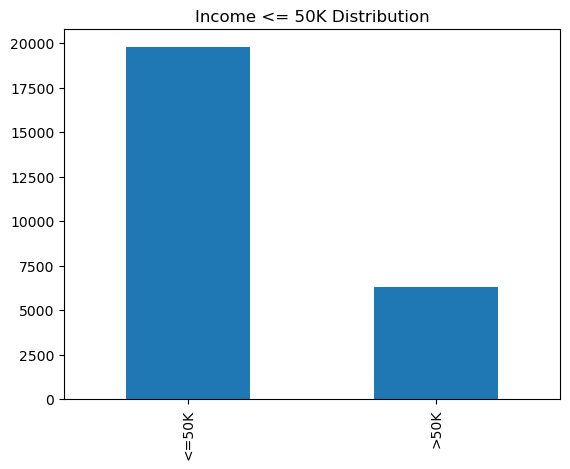

In [11]:
df['income'].value_counts().plot(kind='bar')
plt.title('Income <= 50K Distribution')
plt.show()


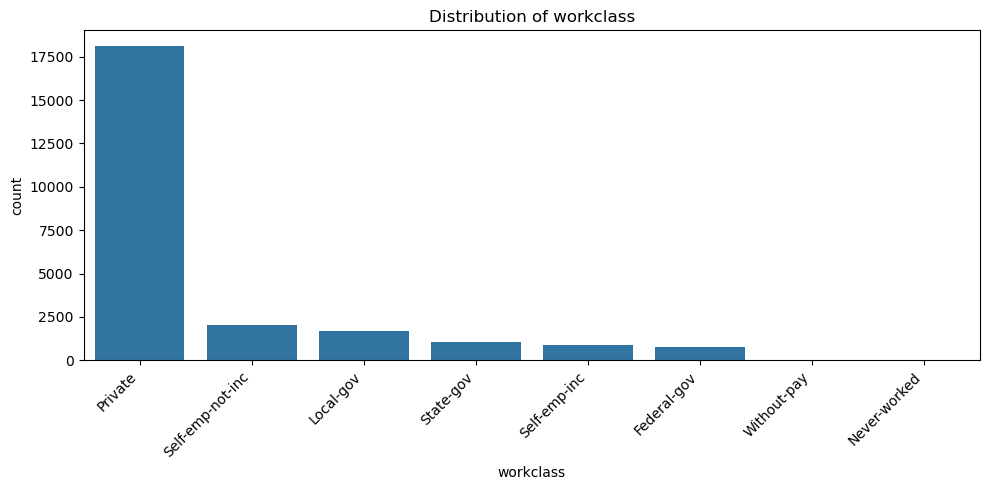

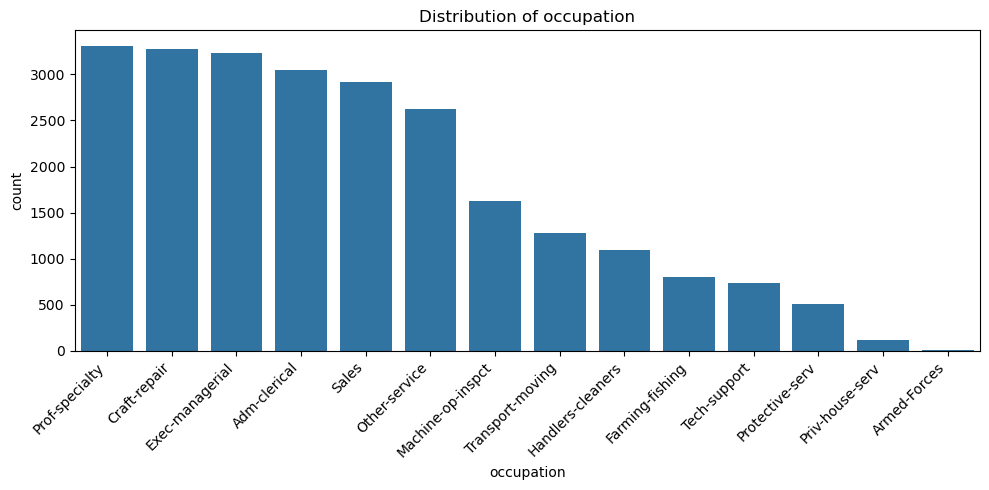

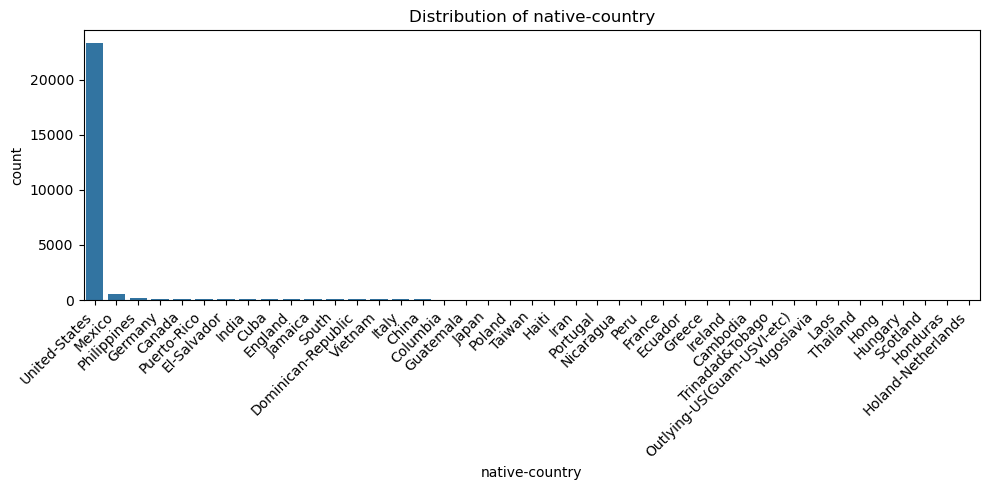

In [12]:


# Ploting distributions for columns with missing values
cols_to_plot = ['workclass', 'occupation', 'native-country']

for col in cols_to_plot:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


In [13]:
#Impute missing values in each column with its mode
for col in df.columns:
    df[col] = df[col].fillna(df[col].mode()[0])
for col in df_val.columns:
    df_val[col] = df_val[col].fillna(df_val[col].mode()[0])

In [14]:
# Encoding and spliting data

TEST_SIZE   = 0.20
RANDOM_SEED = 35

categorical_cols = ['workclass','education','marital-status','occupation',
                    'relationship','race','sex','native-country']
numerical_cols   = ['age','fnlwgt','education-num','capital-gain',
                    'capital-loss','hours-per-week']

# clean column names
df.columns = (df.columns.str.strip()
                        .str.lower()
                        .str.replace(r'\s+', '-', regex=True))

df = pd.get_dummies(df, columns=[c for c in categorical_cols if c in df.columns],
                    drop_first=True)

# split features and target
X = df.drop(columns=['income'])
y = df['income'].map({">50K": 1, "<=50K": 0})

X_train_df, X_test_df, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y
)

# Scale numeric columns
scaler = StandardScaler()
X_train_df[numerical_cols] = scaler.fit_transform(X_train_df[numerical_cols])
X_test_df[numerical_cols]  = scaler.transform(X_test_df[numerical_cols])

# Convert to NumPy
X_train = X_train_df.to_numpy(dtype=np.float64)
X_test  = X_test_df.to_numpy(dtype=np.float64)
y_train = y_train.to_numpy(dtype=np.int64)
y_test  = y_test.to_numpy(dtype=np.int64)

print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")


X_train: (20838, 98), X_test: (5210, 98)
y_train: (20838,), y_test: (5210,)


Perceptron Model

Hard coded version

In [15]:
class Perceptron:
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
      Bias unit after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        # if you use libarry versions stated by book use float_, else if new use float64
        # self.b_ = np.float_(0.)
        self.b_ = np.float64(0.)
        
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_ += update * xi
                self.b_ += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)

In [16]:
#model training 
ppn = Perceptron(eta=0.5, n_iter=10, random_state=1)
ppn.fit(X_train, y_train)

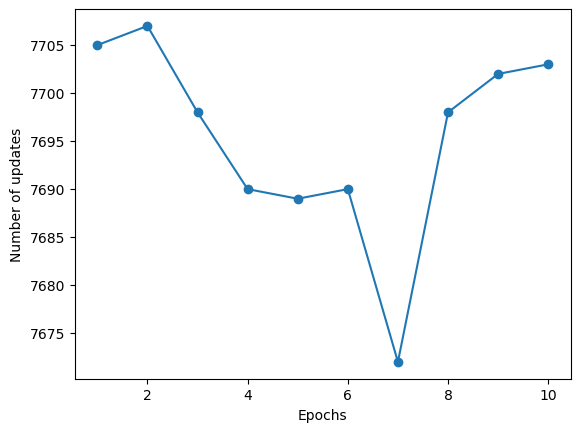

In [17]:
# Plot miscalssificaiotn error for each epoch
plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')

# plt.savefig('images/02_07.png', dpi=300)
plt.show()

In [ ]:
#Scikit Learn version

In [23]:
# Clara
# Implemetation of Scikit-Learn to train a Logistic Regression Model

# The idea of a balanced dataset is very important when evaluating machine learning models.

print("Distribution of outcomes for the training set.")
train_counts = np.bincount(y_train)
print(train_counts)
print(train_counts / train_counts.sum() * 100)

print("Distribution of outcomes for the testing set.")
test_counts = np.bincount(y_test)
print(test_counts)
print(test_counts / test_counts.sum() * 100)

# Compute a ratio of the positive outcomes, versus the negative outcomes.
imbalance_ratio = train_counts.max() / train_counts.min()
print(f"\nImbalance Ratio (Train Set): {imbalance_ratio:.2f}:1")

Distribution of outcomes for the training set.
[15822  5016]
[75.928592 24.071408]
Distribution of outcomes for the testing set.
[3956 1254]
[75.93090211 24.06909789]

Imbalance Ratio (Train Set): 3.15:1


In [ ]:
# Unbalanced Logistic Regression
log_reg = LogisticRegression(
    solver="lbfgs",      
    max_iter=1000,
    random_state=RANDOM_SEED
)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

print("Unbalanced Logistic Regression (i.e., the default)")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(classification_report(y_test, y_pred_lr, target_names=["<=50K", ">50K"]))

Unbalanced Logistic Regression (i.e., the default)
Accuracy: 0.8175
              precision    recall  f1-score   support

       <=50K       0.85      0.92      0.88      3956
        >50K       0.66      0.49      0.57      1254

    accuracy                           0.82      5210
   macro avg       0.76      0.71      0.73      5210
weighted avg       0.81      0.82      0.81      5210



In [30]:
# Balanced Logistic Regression
log_reg_balanced = LogisticRegression(
    solver="lbfgs",
    max_iter=1000,
    random_state=RANDOM_SEED,
    class_weight="balanced"   # <-- key difference
)

# Train model
log_reg_balanced.fit(X_train, y_train)

# Predict
y_pred_lr_balanced = log_reg_balanced.predict(X_test)

# Results
print("Balanced Logistic Regression")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr_balanced):.4f}")
print(classification_report(y_test, y_pred_lr_balanced, target_names=["<=50K", ">50K"]))


Balanced Logistic Regression
Accuracy: 0.7635
              precision    recall  f1-score   support

       <=50K       0.93      0.75      0.83      3956
        >50K       0.51      0.82      0.63      1254

    accuracy                           0.76      5210
   macro avg       0.72      0.78      0.73      5210
weighted avg       0.83      0.76      0.78      5210



In [ ]:
from sklearn.linear_model import LogisticRegressionCV

# Logistic Regression with cross-validation 
log_reg_cv = LogisticRegressionCV(
    Cs=10,                  # Evaluate 10 different values of C
    cv=5,                   # 5-fold
    solver="lbfgs",
    max_iter=1000,
    random_state=RANDOM_SEED,
    n_jobs=-1
)

log_reg_cv.fit(X_train, y_train)
y_pred_lr_cv = log_reg_cv.predict(X_test)

print("Logistic Regression with Cross-Validation")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr_cv):.4f}")
print(classification_report(y_test, y_pred_lr_cv, target_names=["<=50K", ">50K"]))


Logistic Regression with Cross-Validation
Accuracy: 0.8324
              precision    recall  f1-score   support

       <=50K       0.86      0.93      0.89      3956
        >50K       0.71      0.52      0.60      1254

    accuracy                           0.83      5210
   macro avg       0.78      0.73      0.75      5210
weighted avg       0.82      0.83      0.82      5210



In [ ]:
# Logistic Regression with Cross-Validation and L2 regularization
log_reg_cv_l2 = LogisticRegressionCV(
    Cs=np.logspace(-3, 3, 10),   # explore C from 0.001 to 1000
    cv=5,
    penalty="l2",
    solver="lbfgs",
    max_iter=2000,
    scoring="f1",                # optimize for F1 score instead of accuracy
    random_state=RANDOM_SEED,
    n_jobs=-1
)

log_reg_cv_l2.fit(X_train, y_train)
y_pred_cv_l2 = log_reg_cv_l2.predict(X_test)

print("\nLogistic Regression (CV tuned, L2 penalty)")
print(f"Best C: {log_reg_cv_l2.C_[0]}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_cv_l2):.4f}")
print(classification_report(y_test, y_pred_cv_l2, target_names=["<=50K", ">50K"]))

# 2. Logistic Regression with Cross-Validation and L1 regularization
log_reg_cv_l1 = LogisticRegressionCV(a
    Cs=np.logspace(-3, 3, 10),
    cv=5,
    penalty="l1",
    solver="saga",               # saga supports L1
    max_iter=3000,
    scoring="f1",
    random_state=RANDOM_SEED,
    n_jobs=-1
)

log_reg_cv_l1.fit(X_train, y_train)
y_pred_cv_l1 = log_reg_cv_l1.predict(X_test)

print("\nLogistic Regression (CV tuned, L1 penalty)")
print(f"Best C: {log_reg_cv_l1.C_[0]}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_cv_l1):.4f}")
print(classification_report(y_test, y_pred_cv_l1, target_names=["<=50K", ">50K"]))



Logistic Regression (CV tuned, L2 penalty)
Best C: 1000.0
Accuracy: 0.8432
              precision    recall  f1-score   support

       <=50K       0.87      0.94      0.90      3956
        >50K       0.73      0.55      0.63      1254

    accuracy                           0.84      5210
   macro avg       0.80      0.74      0.76      5210
weighted avg       0.84      0.84      0.83      5210



/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not c


Logistic Regression (CV tuned, L1 penalty)
Best C: 0.1
Accuracy: 0.7647
              precision    recall  f1-score   support

       <=50K       0.76      1.00      0.87      3956
        >50K       0.80      0.03      0.06      1254

    accuracy                           0.76      5210
   macro avg       0.78      0.51      0.46      5210
weighted avg       0.77      0.76      0.67      5210



In [34]:
results = []

def run_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=["<=50K", ">50K"], output_dict=True)

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision_>50K": report[">50K"]["precision"],
        "Recall_>50K": report[">50K"]["recall"],
        "F1_>50K": report[">50K"]["f1-score"],
        "Best_C": getattr(model, "C_", None) if hasattr(model, "C_") else None
    })

# Run models
run_model("LogReg (Unbalanced)", LogisticRegression(solver="lbfgs", max_iter=1000, random_state=RANDOM_SEED),
          X_train, y_train, X_test, y_test)

run_model("LogReg (Balanced)", LogisticRegression(solver="lbfgs", max_iter=1000, random_state=RANDOM_SEED, class_weight="balanced"),
          X_train, y_train, X_test, y_test)

run_model("LogReg (CV tuned)", LogisticRegressionCV(Cs=10, cv=5, solver="lbfgs", max_iter=1000, random_state=RANDOM_SEED, n_jobs=-1),
          X_train, y_train, X_test, y_test)

run_model("LogReg (CV tuned, L2)", LogisticRegressionCV(Cs=np.logspace(-3, 3, 10), cv=5, penalty="l2",
                                                         solver="lbfgs", max_iter=2000, scoring="f1",
                                                         random_state=RANDOM_SEED, n_jobs=-1),
          X_train, y_train, X_test, y_test)

run_model("LogReg (CV tuned, L1)", LogisticRegressionCV(Cs=np.logspace(-3, 3, 10), cv=5, penalty="l1",
                                                         solver="saga", max_iter=3000, scoring="f1",
                                                         random_state=RANDOM_SEED, n_jobs=-1),
          X_train, y_train, X_test, y_test)

# Create comparison table
results_df = pd.DataFrame(results).round(4)
print("\n=== Logistic Regression Model Comparison ===")
print(results_df)


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not c


=== Logistic Regression Model Comparison ===
                   Model  Accuracy  Precision_>50K  Recall_>50K  F1_>50K  \
0    LogReg (Unbalanced)    0.8175          0.6617       0.4944   0.5660   
1      LogReg (Balanced)    0.7635          0.5054       0.8206   0.6255   
2      LogReg (CV tuned)    0.8324          0.7064       0.5199   0.5990   
3  LogReg (CV tuned, L2)    0.8432          0.7332       0.5478   0.6271   
4  LogReg (CV tuned, L1)    0.7647          0.8043       0.0295   0.0569   

                   Best_C  
0                    None  
1                    None  
2  [0.005994842503189409]  
3                [1000.0]  
4                   [0.1]  
